In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
! echo $OMP_NUM_THREADS

40


In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits

# File Loading

We specify the filepaths here.

In [3]:
planck_project = '/tigress/zequnl/cmb/software/PSpipe/project/Planck/'

In [4]:
pol_efficiency = {
    '100' : 0.9995,
    '143' : 0.999,
    '217' : 0.999
}

In [5]:
project_dir = '/tigress/zequnl/cmb/data/planck2018/'
map_dir = f'{project_dir}/maps/PR3/frequencyMaps'
mask_dir = f'{project_dir}/maps/PR3/maskMaps/'
beam_dir = f'{project_dir}/BeamWf_HFI_R3.01/'
nside = 2048
lmax = 2508
freq1 = '143'
freq2 = '143'
split1 = '1'
split2 = '2'

# now the specific combination m1 x m2 we want to do here
beam_Wl_hdu = fits.open(beam_dir + f'Wl_R3.01_plikmask_{freq1}hm{split1}x{freq2}hm{split2}.fits')
mfile_1 = f'{map_dir}/HFI_SkyMap_{freq1}_2048_R3.01_halfmission-{1}.fits'
mfile_2 = f'{map_dir}/HFI_SkyMap_{freq2}_2048_R3.01_halfmission-{2}.fits'

maskfile1 = f'{mask_dir}/COM_Mask_Likelihood-temperature-{freq1}-hm{split1}_2048_R3.00.fits'
maskfile2 = f'{mask_dir}/COM_Mask_Likelihood-temperature-{freq2}-hm{split2}_2048_R3.00.fits'
maskfile1_pol = f'{mask_dir}/COM_Mask_Likelihood-polarization-{freq1}-hm{split1}_2048_R3.00.fits'
maskfile2_pol = f'{mask_dir}/COM_Mask_Likelihood-polarization-{freq2}-hm{split2}_2048_R3.00.fits'

Next, we load in the beams, and then initialize a `namap` with the beams, maps and masks. 

In [6]:
pol_fac = pol_efficiency[freq1]
beam_TT = np.sqrt(beam_Wl_hdu[1].data['TT_2_TT'][0])
beam_EE = np.sqrt(beam_Wl_hdu[2].data['EE_2_EE'][0])
beam_BB = np.sqrt(beam_Wl_hdu[3].data['BB_2_BB'][0])
beam_TE = np.sqrt(beam_Wl_hdu[4].data['TE_2_TE'][0])

In [7]:
m1_map_I = hp.read_map(mfile_1, field=0, verbose=False)
m1_map_Q = hp.read_map(mfile_1, field=1, verbose=False) * pol_fac
m1_map_U = hp.read_map(mfile_1, field=2, verbose=False) * pol_fac

m2_map_I = hp.read_map(mfile_2, field=0, verbose=False)
m2_map_Q = hp.read_map(mfile_2, field=1, verbose=False) * pol_fac
m2_map_U = hp.read_map(mfile_2, field=2, verbose=False) * pol_fac

mask1 = hp.read_map(maskfile1, verbose=False)
mask2 = hp.read_map(maskfile2, verbose=False)
mask1_pol = hp.read_map(maskfile1_pol, verbose=False)
mask2_pol = hp.read_map(maskfile2_pol, verbose=False)

/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


KeyboardInterrupt: 

In [ ]:
# convert from K_CMB to μK_CMB
m1_map_I *= 1e6
m1_map_Q *= 1e6
m1_map_U *= 1e6
m2_map_I *= 1e6
m2_map_Q *= 1e6
m2_map_U *= 1e6

In [ ]:
m1 = nw.namap(
    map_I=m1_map_I, mask_temp=mask1, beam_temp=beam_TT, 
    map_Q=m1_map_Q, map_U=m1_map_U, mask_pol=mask1_pol, beam_pol=beam_EE,
    unpixwin=True,
    nside=nside, sub_monopole=True, sub_dipole=True)
m2 = nw.namap(
    map_I=m2_map_I, mask_temp=mask2, beam_temp=beam_TT, 
    map_Q=m2_map_Q, map_U=m2_map_U, mask_pol=mask2_pol, beam_pol=beam_EE,
    unpixwin=True,
    nside=nside, sub_monopole=True, sub_dipole=True)

Next, we compute the mode coupling matrix from the first two fields. We will reuse this for all spectra calculations.

In [ ]:
bins = nw.get_unbinned_bins(lmax)

In [ ]:
## uncomment to recompute
# mc = nw.mode_coupling(m1, m2, bins)
# mc.write_to_dir('data/143x143')
mc = nw.mode_coupling(mcm_dir='data/143x143')

In [ ]:
Cb = nw.compute_spectra(m1, m2, mc=mc)

In [ ]:
plt.plot(Cb['ell'][:1000], Cb['EE'][:1000] * Cb['ell'][:1000]**2)

In [ ]:
Cl12 = nw.compute_spectra(m1, m2, mc=mc)
Cl11 = nw.compute_spectra(m1, m1, mc=mc)
Cl22 = nw.compute_spectra(m2, m2, mc=mc)

In [ ]:
from astropy.io import ascii
th = ascii.read('theory.txt')
fg = ascii.read('fg.txt')

In [ ]:
def ap(x): return np.hstack( ((0.0,0.0), x) )
ell_fac = fg['l'][:2507] * (fg['l'][:2507]+1) / (2 * np.pi)
tot_cltt =  ap((th['TT'] + fg['TT143X143'][:2507])/ell_fac)

In [ ]:
pl = nw.planck.PlanckCov(
    ellspath=f'{planck_project}/planck_spectra/vec_all_spectra.dat')
ell, cl, err, _  = pl.get_subcov('TT_143x143', debug=True)

In [ ]:
binleft, binright = np.genfromtxt(
    '/tigress/zequnl/cmb/software/PSpipe/project/Planck/planck_spectra/binused.dat',
    unpack=True, usecols=(0,1), dtype=((int), (int)))

In [ ]:
Cb = nw.bin_spec_dict(Cl12, binleft, binright, lmax)
Cb11 = nw.bin_spec_dict(Cl11, binleft, binright, lmax)
Cb22 = nw.bin_spec_dict(Cl22, binleft, binright, lmax)

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(12,12))
for ax, spec in zip(axes, ['TT', 'TE', 'EE']):
    lb = Cb['ell']
    
    ell, cl, err, subcov  = pl.get_subcov(
        f'{spec}_{freq1}x{freq2}', debug=True)
    dl_ref_fac = ell*(ell+1)/(2*np.pi)
    ref_filt = np.in1d(lb, ell)
    if spec == 'TE':
        diy_spec = (Cb['TE'][ref_filt] + Cb['ET'][ref_filt])/ 2.0
    else:
        diy_spec = Cb[spec][ref_filt]
    ax.plot(ell, (diy_spec - (cl)) / (err), 'k.-', label=spec)
    ax.axhline(0, color='red', alpha=0.3)
    ax.set_ylabel(r'$\Delta C_{\ell} / \sigma(C_{\ell})$')
    ax.set_title(f'{spec} {freq1}x{freq2}')
plt.tight_layout()

In [ ]:
plt.plot(Cl12['ell'], Cl12['TT'])

l, dl = np.genfromtxt('bestfit.txt', unpack=True, usecols=(0,1))
cl = dl / (l * (l+1)) * np.pi * 2
plt.plot(l, cl)
plt.yscale('log')

In [ ]:
plt.plot(Cl12['TT'] / cl)
plt.ylim(-2,3)
# plt.yscale('log')

## Load Bestfits

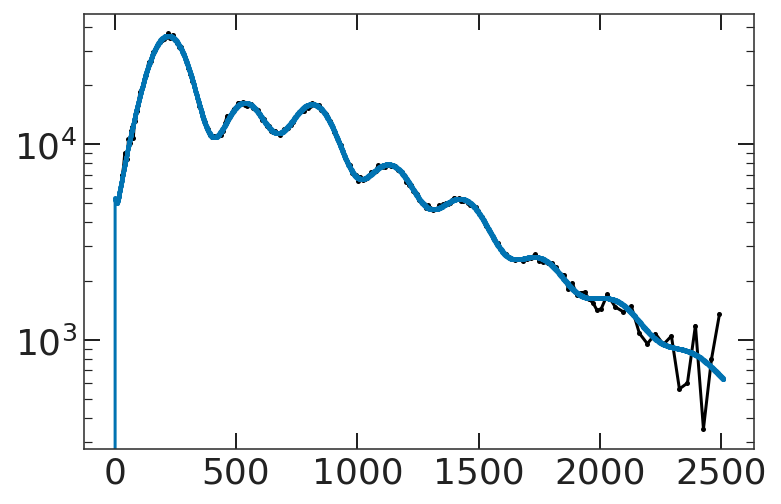

In [23]:
plt.plot(lb, Cb['TT'] * lb**2)
plt.plot( tot_cltt * np.arange(2509)**2)
plt.yscale('log')

In [24]:
n_ell = len(bins.get_effective_ells())
ell_cov, cl, err, cov_plic = pl.get_subcov('TT_143x143', debug=True)

TT_143x143 136 335


In [25]:
from scipy.signal import savgol_filter
nl_tt = ap( savgol_filter( (Cl11['TT'] + Cl22['TT'])/2.0 - Cl12['TT'], 21, 3))
nl_ee = ap( (Cl11['EE'] + Cl22['EE'])/2.0 - Cl12['EE'] )

In [ ]:
plt.plot(cov.noise['TT'])

In [27]:
cov = nw.nacov(m1, m2, mc, signal={'TT' : tot_cltt}, smoothing_window=101)

/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until


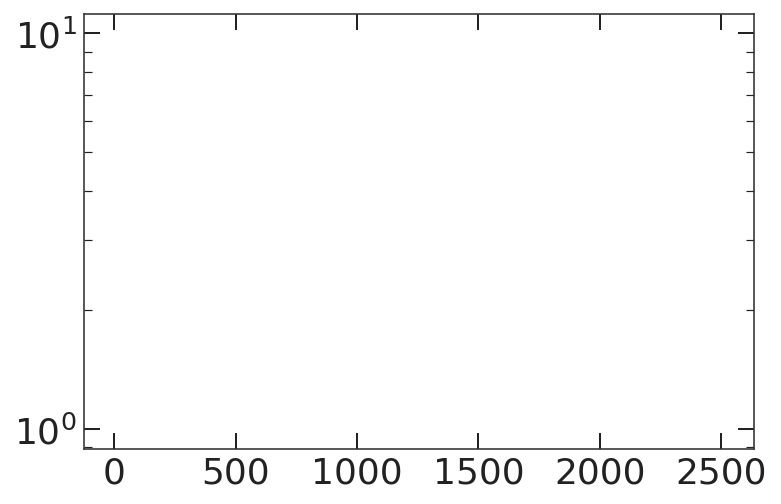

In [40]:
# plt.plot(cov.signal['TT'] * np.arange(2509)**2)
plt.plot( cov.noise['TT'] * np.arange(2509)**2 )
plt.yscale('log')

(-2, 5)

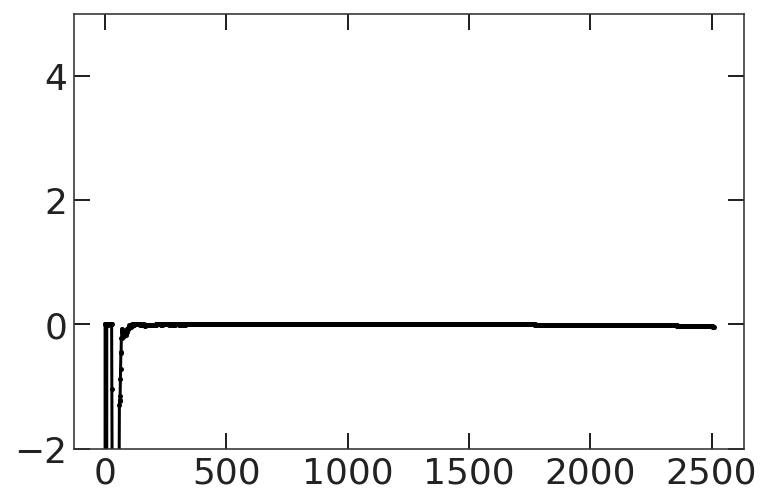

In [29]:
plt.plot( cov.noise['TT'] - nl_tt)
plt.ylim(-2,5)

In [30]:
planck_project = '/tigress/zequnl/cmb/software/PSpipe/project/Planck/'
pl = nw.planck.PlanckCov(
    ellspath=f'{planck_project}/planck_spectra/vec_all_spectra.dat')

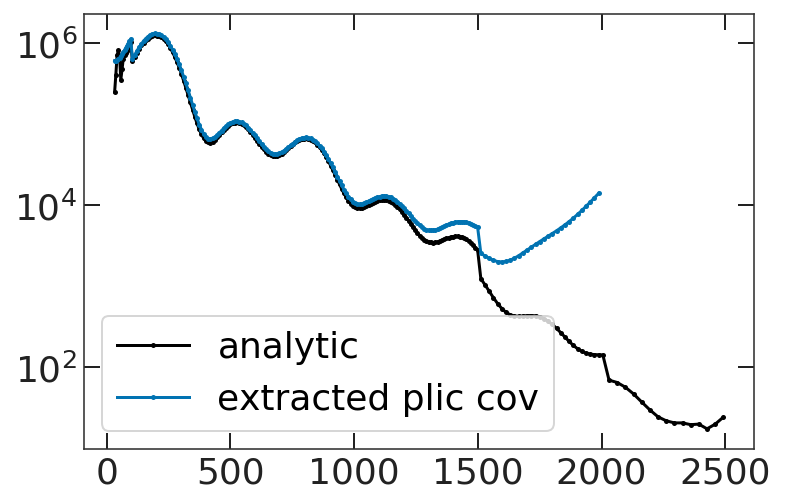

In [36]:
ell_sub_list = [np.arange(l, r) for (l, r) in zip(binleft, binright+1)]

binned_cov = np.zeros((len(ell_sub_list), len(ell_sub_list)))
lb = np.array([ (l+r)/2.0 for l,r in zip(binleft, binright) ])
for i, (bin_i) in enumerate( zip(binleft, binright+1) ):
    for j, (bin_j) in enumerate( zip(binleft, binright+1) ):
        binned_cov[i,j] = np.mean( cov.covar_TT_TT[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )

plt.plot(lb, np.diag(binned_cov) * lb**4, label='analytic')
plt.plot( ell_cov, np.diag(cov_plic) * ell_cov**4, label="extracted plic cov" )
plt.yscale('log')
plt.legend()

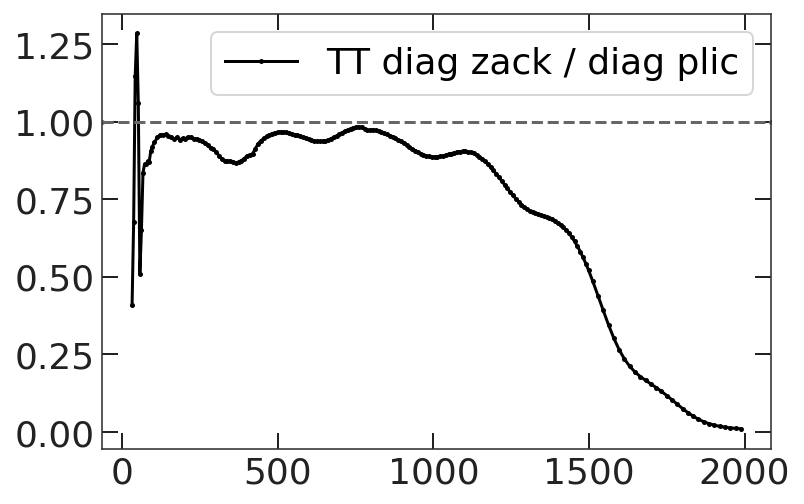

In [35]:
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) / pixwin_T[l.astype(int)]**4 )
plt.plot( ell_cov,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)), label='TT diag zack / diag plic' )

plt.legend()
# plt.plot( l,  np.diag(binned_cov)[:199] / (np.diag(cov_plic)) * pixwin_T[l.astype(int)]**4 )
# plt.ylim(0.5, 1.5)
plt.gca().axhline(1.0,ls='--')

---

In [ ]:
%%time
cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(m1.field_spin0,m1.field_spin0, m2.field_spin0, m2.field_spin0, lmax=lmax)

In [31]:
n_ell = len(bins.get_effective_ells())
ell_cov, cl, err, cov_plic = pl.get_subcov('TT_143x143', debug=True)

TT_143x143 136 335


In [ ]:
# n_ell

In [ ]:
plt.plot( Cb['ell'], savgol_filter(Cb['TT'],11,3) * Cb['ell']**2 )
plt.plot( Cb['ell'], Cb['TT'] * Cb['ell']**2, alpha=0.5 )
plt.yscale('log')

In [ ]:
cl_tt = np.interp(x=np.arange(2509), xp=Cb['ell'], fp=savgol_filter(Cb['TT'],11,3), right=0)
cl_ee = np.interp(x=np.arange(2509), xp=Cb['ell'], fp=savgol_filter(Cb['EE'],11,3), right=0)

In [ ]:
%%time
beam_tt = (beam_TT[:lmax+1])**2
covar_00_00 = nmt.gaussian_covariance(cw,
                                      0, 0, 0, 0,  # Spins of the 4 fields
                                      [(cl_tt + nl_tt) * beam_tt],  # TT
                                      [cl_tt * beam_tt],  # TT
                                      [cl_tt * beam_tt],  # TT
                                      [(cl_tt + nl_tt) * beam_tt],  # TT
                                      mc.w00, wb=mc.w00).reshape([n_ell, 1,
                                                            n_ell, 1])
covar_TT_TT = covar_00_00[:, 0, :, 0]

# USE TOTAL POWER SPECTRUM

Try to smooth the low ell noise! or say it's white

Check the low ell spectrum vs cosmic variance

In [39]:
cl_tb = cl_tt * 0.0
cl_eb = cl_tt * 0.0

beam_ee = (pixwin_P[:lmax+1] * beam_EE[:lmax+1])**2
beam_te = pixwin_P[:lmax+1] * pixwin_T[:lmax+1] * (beam_TE[:lmax+1])**2

In [40]:
%%time
covar_02_02 = nmt.gaussian_covariance(cw, 0, 2, 0, 2,  # Spins of the 4 fields
                                      [(cl_tt + nl_tt) * beam_tt],  # TT
                                      [cl_te * beam_te, cl_tb],  # TE, TB
                                      [cl_te * beam_te, cl_tb],  # ET, BT
                                      [(cl_ee + nl_ee) * beam_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      mc.w02, wb=mc.w02).reshape([n_ell, 2,
                                                            n_ell, 2])
covar_TE_TE = covar_02_02[:, 0, :, 0]
covar_TE_TB = covar_02_02[:, 0, :, 1]
covar_TB_TE = covar_02_02[:, 1, :, 0]
covar_TB_TB = covar_02_02[:, 1, :, 1]

CPU times: user 3min 15s, sys: 2.7 s, total: 3min 18s
Wall time: 3min 1s


In [41]:
%%time
covar_02_02_off = nmt.gaussian_covariance(cw, 0, 2, 0, 2,  # Spins of the 4 fields
                                      [(cl_tt) * beam_tt],  # TT
                                      [cl_te * beam_te, cl_tb],  # TE, TB
                                      [cl_te * beam_te, cl_tb],  # ET, BT
                                      [(cl_ee) * beam_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      mc.w02, wb=mc.w02).reshape([n_ell, 2,
                                                            n_ell, 2])
covar_TE_TE_off = covar_02_02_off[:, 0, :, 0]
covar_TE_TB_off = covar_02_02_off[:, 0, :, 1]
covar_TB_TE_off = covar_02_02_off[:, 1, :, 0]
covar_TB_TB_off = covar_02_02_off[:, 1, :, 1]

CPU times: user 3min 20s, sys: 3.05 s, total: 3min 23s
Wall time: 3min 5s


TE_143x143 1810 2009


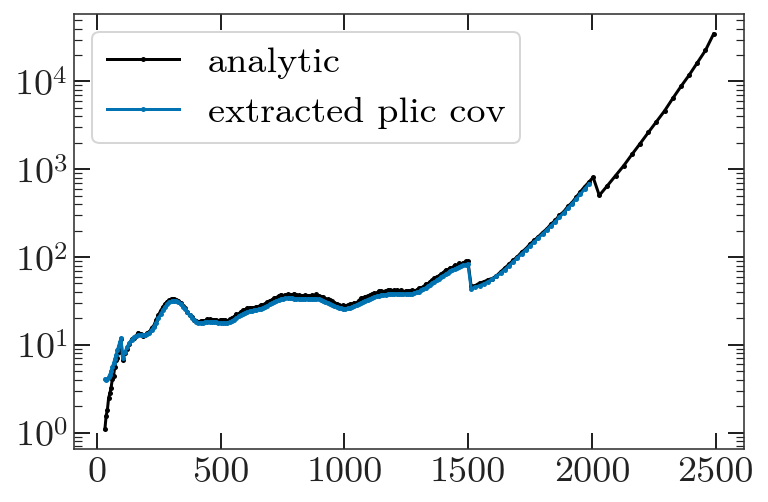

In [55]:
ell_sub_list = [np.arange(l, r) for (l, r) in zip(binleft, binright+1)]

binned_cov = np.zeros((len(ell_sub_list), len(ell_sub_list)))
binned_cov_off = np.zeros((len(ell_sub_list), len(ell_sub_list)))
lb = np.array([ (l+r)/2.0 for l,r in zip(binleft, binright) ])
for i, (bin_i) in enumerate( zip(binleft, binright+1) ):
    for j, (bin_j) in enumerate( zip(binleft, binright+1) ):
        binned_cov[i,j] = np.mean( covar_TE_TE[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )
        binned_cov_off[i,j] = np.mean( covar_TE_TE_off[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )
        
        binned_cov[i,j] = (binned_cov[i,j]*2 + binned_cov_off[i,j]*2) / 4

l, cl, err, cov_plic = pl.get_subcov('TE_143x143', debug=True)
plt.plot(lb, np.diag(binned_cov)  * (lb*(lb+1))**2 / (2 * np.pi)**2, label='analytic')
plt.plot( l, np.diag(cov_plic) * (l*(l+1))**2 / (2 * np.pi)**2, label="extracted plic cov" )


plt.legend()
plt.yscale('log')

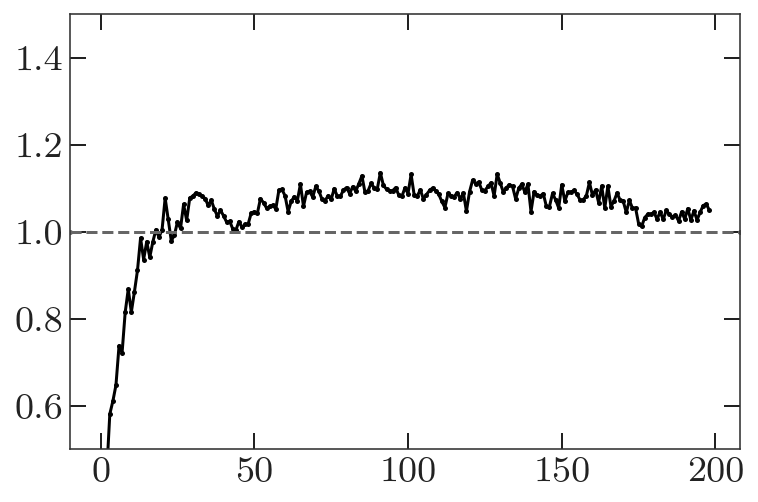

In [56]:
plt.plot( np.diag(binned_cov)[:199] / np.diag(cov_plic) )
plt.ylim(0.5, 1.5)
plt.gca().axhline(1.0,ls='--')

In [34]:
n_ell = len(bins.get_effective_ells())
ell_cov, cl, err, cov_plic = pl.get_subcov('EE_143x143', debug=True)

EE_143x143 1048 1247


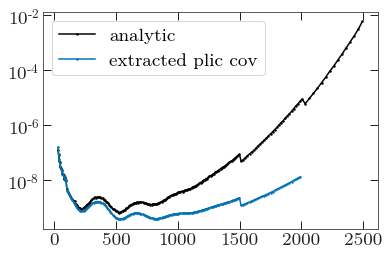

In [35]:
ell_sub_list = [np.arange(l, r) for (l, r) in zip(binleft, binright+1)]

binned_cov = np.zeros((len(ell_sub_list), len(ell_sub_list)))
lb = np.array([ (l+r)/2.0 for l,r in zip(binleft, binright) ])
for i, (bin_i) in enumerate( zip(binleft, binright+1) ):
    for j, (bin_j) in enumerate( zip(binleft, binright+1) ):
        binned_cov[i,j] = np.mean( cov.covar_EE_EE[bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )

plt.plot(lb, np.diag(binned_cov) * 1e24, label='analytic')
plt.plot( ell_cov, np.diag(cov_plic), label="extracted plic cov" )


plt.legend()
plt.yscale('log')

(0.0, 5e-08)

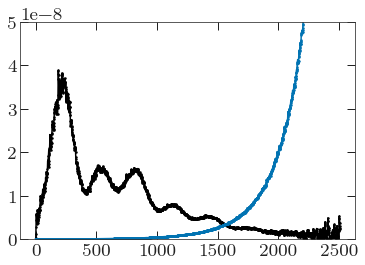

In [49]:
plt.plot(cov.signal['TT'] * np.arange(2509)**2)
plt.plot(cov.noise['TT'] * np.arange(2509)**2)
plt.ylim(0.0, 0.5e-7)

(0.0, 9e-10)

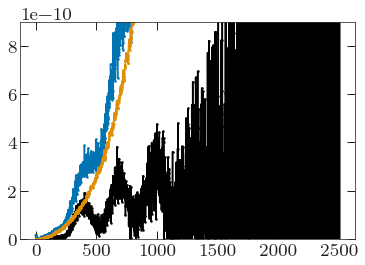

In [56]:
plt.plot(cov.Cl12['EE'] * np.arange(2,2509)**2)
plt.plot(cov.Cl11['EE'] * np.arange(2,2509)**2)
plt.plot(cov.noise['EE'] * np.arange(2509)**2)
plt.ylim(0.0, 0.9e-9)

In [27]:
# %%time
# covar_00_22 = nmt.gaussian_covariance(cw, 0, 0, 2, 2,  # Spins of the 4 fields
#                                       [cl_te, cl_tb],  # TE, TB
#                                       [cl_te, cl_tb],  # TE, TB
#                                       [cl_te, cl_tb],  # TE, TB
#                                       [cl_te, cl_tb],  # TE, TB
#                                       mc.w00, wb=mc.w22).reshape([n_ell, 1,
#                                                             n_ell, 4])
# covar_TT_EE = covar_00_22[:, 0, :, 0]
# covar_TT_EB = covar_00_22[:, 0, :, 1]
# covar_TT_BE = covar_00_22[:, 0, :, 2]
# covar_TT_BB = covar_00_22[:, 0, :, 3]


In [28]:
# %%time
# covar_02_22 = nmt.gaussian_covariance(cw, 0, 2, 2, 2,  # Spins of the 4 fields
#                                       [cl_te, cl_tb],  # TE, TB
#                                       [cl_te, cl_tb],  # TE, TB
#                                       [cl_ee, cl_eb,
#                                        cl_eb, cl_bb],  # EE, EB, BE, BB
#                                       [cl_ee, cl_eb,
#                                        cl_eb, cl_bb],  # EE, EB, BE, BB
#                                       mc.w02, wb=mc.w22).reshape([n_ell, 2,
#                                                             n_ell, 4])
# covar_TE_EE = covar_02_22[:, 0, :, 0]
# covar_TE_EB = covar_02_22[:, 0, :, 1]
# covar_TE_BE = covar_02_22[:, 0, :, 2]
# covar_TE_BB = covar_02_22[:, 0, :, 3]
# covar_TB_EE = covar_02_22[:, 1, :, 0]
# covar_TB_EB = covar_02_22[:, 1, :, 1]
# covar_TB_BE = covar_02_22[:, 1, :, 2]
# covar_TB_BB = covar_02_22[:, 1, :, 3]

In [41]:
beam_ee = (m1.beam_pol * m2.beam_pol)[:cov.lmax+1]

In [29]:
%%time
covar_22_22 = nmt.gaussian_covariance(cov.cw, 2, 2, 2, 2,  # Spins of the 4 fields
                                      [.signal['EE'], self.signal['EB'],
                                       self.signal['EB'], self.signal['BB']],  # EE, EB, BE, BB
                                      [self.signal['EE'], self.signal['EB'],
                                       self.signal['EB'], self.signal['BB']],  # EE, EB, BE, BB
                                      [self.signal['EE'], self.signal['EB'],
                                       self.signal['EB'], self.signal['BB']],  # EE, EB, BE, BB
                                      [self.signal['EE'], self.signal['EB'],
                                       self.signal['EB'], self.signal['BB']],  # EE, EB, BE, BB
                                      mc.w22, wb=mc.w22).reshape([n_ell, 4,
                                                            n_ell, 4])
covar_EE_EE = covar_22_22[:, 0, :, 0]
covar_EE_EB = covar_22_22[:, 0, :, 1]
covar_EE_BE = covar_22_22[:, 0, :, 2]
covar_EE_BB = covar_22_22[:, 0, :, 3]
covar_EB_EE = covar_22_22[:, 1, :, 0]
covar_EB_EB = covar_22_22[:, 1, :, 1]
covar_EB_BE = covar_22_22[:, 1, :, 2]
covar_EB_BB = covar_22_22[:, 1, :, 3]
covar_BE_EE = covar_22_22[:, 2, :, 0]
covar_BE_EB = covar_22_22[:, 2, :, 1]
covar_BE_BE = covar_22_22[:, 2, :, 2]
covar_BE_BB = covar_22_22[:, 2, :, 3]
covar_BB_EE = covar_22_22[:, 3, :, 0]
covar_BB_EB = covar_22_22[:, 3, :, 1]
covar_BB_BE = covar_22_22[:, 3, :, 2]
covar_BB_BB = covar_22_22[:, 3, :, 3]